# Imports

In [1]:
import sys
import os
import cPickle as pickle
import numpy as np
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']
mpl.rcParams['font.size'] = 22
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
import matplotlib.pyplot as plt

gleam_root = "/Users/phdenzel/gleam"
sys.path.append(gleam_root)
import gleam
from gleam.multilens import MultiLens
from gleam.utils.lensing import LensModel
from gleam.reconsrc import ReconSrc
from gleam.lightsampler import LightSampler
from gleam.starsampler import StarSampler
from gleam.utils.lensing import enc_profile
from gleam.utils.lensing import dispersion_profile
from gleam.utils.plotting import kappa_map_plot, kappa_profiles_plot
from gleam.utils.plotting import arrival_time_surface_plot
from gleam.utils.plotting import plot_scalebar, plot_labelbox
from gleam.utils.rgb_map import lupton_like, grayscale
import gleam.utils.units as glu
import gleam.utils.colors as gcl


In [2]:
extension = 'pdf'


# Lens models

In [3]:
statefile = 'gls/012771.state'
# statefile = 'gls/N7LTELSYTM.state'
# statefile = 'gls/sw05.state'
print(statefile)


gls/012771.state


In [4]:
lm = LensModel(statefile)
print(lm.__v__)


filename            	012771.state
filepath            	gls/012771.state
N                   	200
pixrad              	12
maprad              	8.52937665444
pixel_size          	0.227450044118
kappa               	55659503266.0
minima              	[[ 1.347  5.29 ]
 [-4.249 -2.3  ]]
saddle_points       	[[-4.68  -0.238]
 [ 2.472 -2.252]]
maxima              	[]
zl                  	0.66
zs                  	3.0
N_obj               	1
N_src               	1
obj_idx             	0
src_idx             	0


## Lens observations

In [5]:
lensfiles = !ls data/*.fits
key_sorter = {'U': 0, 'G': 1, 'R': 2, 'I': 3, 'I2': 4, 'Z': 5}
lensfiles = sorted(lensfiles, key=lambda f: key_sorter[f.split('.')[1]])
print(lensfiles)


['data/W3+3-2.U.12909_13036_7445_7572.fits', 'data/W3+3-2.G.12909_13036_7445_7572.fits', 'data/W3+3-2.R.12909_13036_7445_7572.fits', 'data/W3+3-2.I.12909_13036_7445_7572.fits', 'data/W3+3-2.I2.12909_13036_7445_7572.fits', 'data/W3+3-2.Z.12909_13036_7445_7572.fits']


In [6]:
ml = MultiLens(lensfiles)
ml['i'].data = np.flipud(ml['i'].data[:])
for b in ml.bands:
    ml[b].zl = lm.zl
    ml[b].zs = lm.zs
print(ml.__v__)


N                   	6
filepaths           	['/Users/phdenzel/sw05/data/W3+3-2.U.12909_13036_7445_7572.fits', '/Users/phdenzel/sw05/data/W3+3-2.G.12909_13036_7445_7572.fits', '/Users/phdenzel/sw05/data/W3+3-2.R.12909_13036_7445_7572.fits', '/Users/phdenzel/sw05/data/W3+3-2.I.12909_13036_7445_7572.fits', '/Users/phdenzel/sw05/data/W3+3-2.I2.12909_13036_7445_7572.fits', '/Users/phdenzel/sw05/data/W3+3-2.Z.12909_13036_7445_7572.fits']
files               	['W3+3-2.U.12909_13036_7445_7572.fits', 'W3+3-2.G.12909_13036_7445_7572.fits', 'W3+3-2.R.12909_13036_7445_7572.fits', 'W3+3-2.I.12909_13036_7445_7572.fits', 'W3+3-2.I2.12909_13036_7445_7572.fits', 'W3+3-2.Z.12909_13036_7445_7572.fits']
fs                  	[LensObject(u@[218.7258, 52.4808]), LensObject(g@[218.7258, 52.4808]), LensObject(r@[218.7258, 52.4808]), LensObject(i@[218.7258, 52.4808]), LensObject(i@[218.7258, 52.4808]), LensObject(z@[218.7258, 52.4808])]
bands               	['u', 'g', 'r', 'i', 'i', 'z']
naxis1              	[1

In [7]:
best_pars = {'x': 59.02099903821723, 'y': 58.9346344410624,
             'I_0': 29.49507094039217,
             'n': 1.4974741188141885, 'c_0': 0.0,
             'e': 0.11663097506313133,
             'phi': 3.464562637198838+90,
             'r_s': 8.976805452180514 * (100./128),
}
lsampler = LightSampler.from_gleamobj(ml, verbose=0)
lsampler.parameters = best_pars
ml['i'].light_model = lsampler.model
print lsampler.parameters


{'phi': 93.46456263719884, 'e': 0.11663097506313133, 'r_s': 7.013129259516027, 'n': 1.4974741188141885, 'c_0': 0.0, 'y': 58.9346344410624, 'x': 59.02099903821723, 'I_0': 29.49507094039217}


In [8]:
# from MCMC (hardcoded, resampling would take too long)
m_stel = [3.04e+11 - 5*0.22e+11, 3.04e+11, 3.04e+11 + 5*0.22e+11]
print "{:e}".format(m_stel[1])

3.040000e+11


In [9]:
# lower limit
ml['i'].stel_mass = m_stel[0]
stelmin_map = ml['i'].stel_map
# upper limit
ml['i'].stel_mass = m_stel[2]
stelmax_map = ml['i'].stel_map
# median
ml['i'].stel_mass = m_stel[1]
stel_map = ml['i'].stel_map

pxkpc = ml['i'].px2arcsec[0]*lm.arcsec2kpc[-1]
_, stel_pmin = enc_profile(stelmin_map)
_, stel_pmax = enc_profile(stelmax_map)
rad, stel_prf = enc_profile(stel_map)
stel_rad = rad * pxkpc

# plt.imshow(stel_map, cmap='phoenix', extent=ml['i'].extent, vmax=3e+9)
# plt.colorbar()



## Profiling

In [10]:
def halflight_radius(R, M):
    """
    Get interpolated halflight radius with neighboring indices
    from lists of masses and radii
    """
    halflM = 0.5*M[-1]
    idx = np.argmin(np.abs(M - halflM))
    if M[idx+1] > halflM > M[idx]:
        x1 = M[idx+1]
        y1 = R[idx+1]
        x0 = M[idx]
        y0 = R[idx]
        x = halflM
        idx0 = idx
        idx1 = idx+1
    else:
        x1 = M[idx]
        y1 = R[idx]
        x0 = M[idx-1]
        y0 = R[idx-1]
        x = halflM
        idx0 = idx-1
        idx1 = idx
    halfR_lerp = y0*(1-(x-x0)/(x1-x0))+y1*((x-x0)/(x1-x0))
    return halfR_lerp, (idx0, idx1)

def T2sigma(temp):
    """
    Get the analytical velocity dispersion in units of km/s for an equilibrium
    temperature in units of eV
    """
    mp = 1.672621898e-27  # kg
    me = 9.10938356e-31   # kg
    sigma = np.sqrt(temp * 1e-6 * glu.e / mp)  # km/s
    return sigma


def sigma2T(sigma):
    """
    Get the analytical equilibrium temperature in units of eV for the
    velocity dispersion in units of km/s
    """
    mp = 1.672621898e-27  # kg
    me = 9.10938356e-31   # kg
    sigma2 = 1e6 * sigma * sigma  # m^2/s^2
    temp = mp * sigma2 / glu.e  # eV
    return temp


def nearestMinMag(x):
    """
    Calculate nearest order of magnitude for x
    """
    minmag = 100
    for i in x:
        nmag = np.round(np.log10(i))
        if nmag < minmag:
            minmag = nmag
    return x - x % 10**minmag, minmag


In [11]:
def idkey_remap(key):
    if key == 'TL00003 (z=0.6)':
        return 'C1'
    elif key == 'TL00113 (z=0.5)':
        return 'A4'
    elif key == 'TL00206 (z=0.5)':
        return 'A1'
    elif key == 'TL00017 (z=0.6)':
        return 'D7'


def idkey_redsh(key):
    if key == 'TL00003 (z=0.6)':
        return 0.6
    elif key == 'TL00113 (z=0.5)':
        return 0.5
    elif key == 'TL00206 (z=0.5)':
        return 0.5
    elif key == 'TL00017 (z=0.6)':
        return 0.6


In [12]:
firefiles = {
    'TL00003 (z=0.6)': 'savestates/fire/B100_N512_M3e13_TL00003_baryon_toz0_LR_9915.z0.600.AHF_profiles.pkl',
    'TL00113 (z=0.5)': 'savestates/fire/B100_N512_TL00113_baryon_toz0_9915.z0.510.AHF_profiles.pkl',
    'TL00206 (z=0.5)': 'savestates/fire/B100_N512_TL00206_baryon_toz0_9915.z0.510.AHF_profiles.pkl',
    'TL00017 (z=0.6)': 'savestates/fire/B100_N512_z0_13.5_TL00017_baryon_toz0_9915.z0.600.AHF_profiles.pkl',
}

In [13]:
fire_profs = {}
for k in firefiles:
    with open(firefiles[k], 'rb') as f:
        dta = pickle.load(f)
        fire_profs[k] = dta


In [14]:
# sanitize
for k in firefiles:
    dta = fire_profs[k]
    dta[1] = np.array([d if dta[1][max(i-1, 0)] < d else dta[1][max(i-1, 0)] for i, d in enumerate(dta[1])])
    dta[2] = np.array([d if dta[2][max(i-1, 0)] < d else dta[2][max(i-1, 0)] for i, d in enumerate(dta[2])])
    fire_profs[k] = np.array(dta[:])


In [15]:
# # Correct the comoving distances
fire_profs_comov = fire_profs
hmult = lambda x: x/0.72
hmultprprd = lambda x: x/0.72/(1.+z)
for k in fire_profs:
    z = idkey_redsh(k)
    dta = fire_profs[k]
    # correct h factor: H_0 = h * 100 km/s/Mpc; vanilla cosmology: h~0.72
    # comoving coordinates/(1+z) = angular coords (as long as omega_k = 0)
    fire_profs_comov[k] = [np.array(map(hmultprprd, dta[0])),
                           np.array(map(hmult, dta[1])),
                           np.array(map(hmult, dta[2]))]


In [16]:
# Rescale FIRE baryons
baryon_scales = {k: stel_prf[-1]/fire_profs_comov[k][2][-1] for k in fire_profs_comov}
for k in fire_profs_comov:
    scale = baryon_scales[k]
    fire_profs_comov[k] = [fire_profs_comov[k][0], scale*fire_profs_comov[k][1], scale*fire_profs_comov[k][2]]

# Rescale FIRE halos
halflightR, _ = halflight_radius(stel_rad, stel_prf)
for k in fire_profs_comov:
    hl, _ = halflight_radius(fire_profs_comov[k][0], fire_profs_comov[k][2])
    scale = halflightR / hl
    fire_profs_comov[k][0] = scale * fire_profs_comov[k][0]

# Even out tail (negative mass artifacts due to interpolation)
for key in fire_profs_comov:
    fd = fire_profs_comov[key]
    prev = fd[1][0]
    for k in range(len(fd[1])):
        if fd[1][k] < prev:
            fire_profs_comov[key][1][k] = prev
        prev = fd[1][k]
    prev = fd[2][0]
    for l in range(len(fd[2])):
        if fd[2][l] < prev:
            fire_profs_comov[key][2][l] = prev
        prev = fd[2][l]


In [17]:
for k in fire_profs_comov:
    print "{:e}".format(fire_profs_comov[k][1][-1])


9.285253e+12
1.150329e+13
1.369079e+13
6.125653e+12


1.121954e+13 +1.196748e+13 / -1.037550e+13 


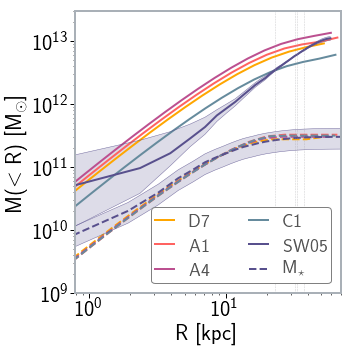

In [18]:
plt.figure(figsize=(5, 5))

palette = gcl.GLEAMcolors.pl5
clrsw05 = palette[-2]
palette = palette[:-2] + palette[-1:]
for k, c in zip(fire_profs_comov, palette):
    dta = fire_profs_comov[k]
    # dark halo
    plt.loglog(dta[0], dta[1], c=c, ls='-', lw=2, label=idkey_remap(k))
    # stellar matter
    plt.loglog(dta[0], dta[2], c=c, ls='--', lw=2)

# lens
rad, prf, pmin, pmax = lm.encmass_profile_range(refined=True, runit='kpc')
# prf = prf * lm.maprad / lm.arcsec2kpc[-1]
# pmin = pmin * lm.maprad / lm.arcsec2kpc[-1]
# pmax = pmax * lm.maprad / lm.arcsec2kpc[-1]


print "{:e} +{:e} / -{:e} ".format(prf[-1], pmax[-1], pmin[-1])


plt.loglog(rad, prf, lw=2, color=clrsw05, label='SW05')
plt.fill_between(rad, pmax, pmin, facecolor=clrsw05, alpha=0.2)
plt.loglog(rad, pmin, lw=0.5, color=clrsw05, alpha=0.8)
plt.loglog(rad, pmax, lw=0.5, color=clrsw05, alpha=0.8)

# stellar mass
plt.loglog(stel_rad, stel_prf, lw=2, ls='--', color=clrsw05, label=r'M$_\star$')
plt.fill_between(stel_rad, stel_pmax, stel_pmin, facecolor=clrsw05, alpha=0.2)
plt.loglog(stel_rad, stel_pmin, lw=0.5, color=clrsw05, alpha=0.8)
plt.loglog(stel_rad, stel_pmax, lw=0.5, color=clrsw05, alpha=0.8)

# images
for d in [lm.arcsec2kpc[-1]*np.sqrt(p[0]**2+p[1]**2) for p in lm.minima] \
    + [lm.arcsec2kpc[-1]*np.sqrt(p[0]**2+p[1]**2) for p in lm.saddle_points]:
    plt.axvline(d, lw=0.5, ls='--', c=gcl.GLEAMcolors.grey, alpha=0.5)

# settings
plt.xlim(0.78, 70)
plt.ylim(1e9, 3e13)
plt.xlabel(r'$\mathsf{R}$ [$\mathsf{kpc}$]', fontsize=22)
plt.ylabel(r'$\mathsf{M}$($\mathsf{<R}$) [$\mathsf{M_{\odot}}$]', fontsize=22)
plt.legend(fontsize=19, loc=4, fancybox=True, ncol=2, numpoints=1,
           handlelength=1, borderpad=0.2, labelspacing=0.3, framealpha=1.)

plt.tight_layout()

savename = 'profiles_SW05_wFIRE.{}'.format(extension)
plt.savefig(os.path.join('plots', savename),
            transparent=True, bbox_inches='tight', pad_inches=0.1)


In [19]:
from gleam.glass_interface import glass_renv
glass = glass_renv()

print "dL \t", lm.dl
print "dlsds\t", lm.dlsds
print "H0 \t", lm.H0[-1]
print "nu \t", lm.nu[-1]
print "kpc\t", lm.arcsec2kpc[-1]
print "kappa\t", lm.kappa

dL 	0.33890035574521704
dlsds	0.6284988144965584
H0 	71.37328467153284
nu 	3.1054927171532847
kpc	6.90477372043063
kappa	55659503266.029175


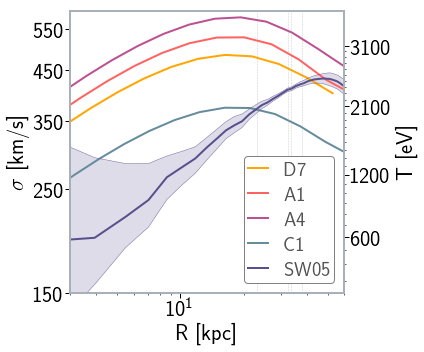

In [20]:
plt.figure(figsize=(6, 5))

for k, c in zip(fire_profs_comov, palette):
    dta = fire_profs[k]
    # dark halo
    _, fire_vdisp = dispersion_profile((dta[0], dta[1]))
    plt.loglog(dta[0], fire_vdisp,
               c=c, ls='-', lw=2, label=idkey_remap(k))

# rad, prf, pmin, pmax
dispv = dispersion_profile((rad, prf))[1]
dispv_min = dispersion_profile((rad, pmin))[1]
dispv_max = dispersion_profile((rad, pmax))[1]
plt.fill_between(rad, dispv_max, dispv_min, facecolor=clrsw05, alpha=0.2)
plt.plot(rad, dispv_min, c=clrsw05, ls='-', lw=0.5, alpha=0.8)
plt.plot(rad, dispv_max, c=clrsw05, ls='-', lw=0.5, alpha=0.8)

# print r, dispv
plt.plot(rad, dispv, c=clrsw05, ls='-', lw=2, label='SW05')
x_label = 'R [kpc]'
y_label = r'$\mathsf{\sigma}$ [km/s]'
y_label2 = 'T [eV]'
plt.xlabel(x_label, fontsize=22)
plt.ylabel(y_label, fontsize=22)
plt.xlim(3, 60)
ymin, ymax = 150, 600
plt.ylim(ymin, ymax)
plt.legend(fontsize=20, loc=4, fancybox=True, numpoints=1,
           handlelength=1, borderpad=0.2, labelspacing=0.3, framealpha=1.)

# images
for d in [lm.arcsec2kpc[-1]*np.sqrt(p[0]**2+p[1]**2) for p in lm.minima] \
    + [lm.arcsec2kpc[-1]*np.sqrt(p[0]**2+p[1]**2) for p in lm.saddle_points]:
    plt.axvline(d, lw=0.5, ls='--', c=gcl.GLEAMcolors.grey, alpha=0.5)

yticks = np.arange(ymin, ymax+0.1, 100)
plt.gca().get_yaxis().set_major_locator(mpl.ticker.FixedLocator(yticks))
plt.gca().get_yaxis().set_minor_locator(mpl.ticker.NullLocator())
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# Temperature scale
ax2 = plt.gca().twinx()
ax2.set_ylim(ymin=ymin, ymax=ymax)
tvals, minmag = nearestMinMag(sigma2T(yticks))
tticks = T2sigma(tvals)  # in units of sigma
minortvals = np.arange(tvals.min(), tvals.max(), 10**minmag)
minortticks = T2sigma(minortvals)
ax2.get_yaxis().set_major_locator(mpl.ticker.FixedLocator(tticks))
ax2.get_yaxis().set_minor_locator(mpl.ticker.FixedLocator(minortticks))
# ax2.get_yaxis().set_minor_locator(mpl.ticker.NullLocator())
ax2.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(
    lambda y, _: r"{:g}".format(sigma2T(y))))
ax2.set_ylabel(y_label2, fontsize=22)

plt.tight_layout()

savename = 'dispersion_SW05_wFIRE.{}'.format(extension)
plt.savefig(os.path.join('plots', savename),
            transparent=True, bbox_inches='tight', pad_inches=0.1)
